In [1]:
# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_10'
similarity_threshold = 0.75  # delta for cosine similarity
alpha = 0.5  # parameter for weighted vector combination of thematic embedding
n_docs = 6  # number of docs to retrieve by RAG
n_components_carag = 3  # number of clusters for CARAG
n_components_carag_u = 10  # number of clusters for CARAG-U

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using the latest cached version of the dataset since manjuvallayil/factver_master couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/qsh5523/.cache/huggingface/datasets/manjuvallayil___factver_master/default/0.0.0/50f3bf76490fd2c7dfa76bb772ddabe2857e4eae (last modified on Fri Dec 20 19:40:27 2024).
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may

In [2]:
import numpy as np
import pandas as pd

# Load dataset and global vectors
dataset_vectors = rag_utils.load_dataset_vectors()  # Global context vectors
print(f"Loaded {len(dataset_vectors)} vectors from the FAISS index.")

# Load the data from the CSV file
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes in results.csv
themes = df['Theme'].unique() if 'Theme' in df.columns else []
print(f"Available themes in results.csv: {themes}")

# Step 1: Extract claim IDs and explanations
claim_ids = df['Claim_id'].tolist()
annotated_explanations = df['Annotated'].tolist()
rag_explanations = df['RAG'].tolist()
carag_explanations = df['CARAG'].tolist()
carag_u_explanations = df['CARAG_U'].tolist()  # New column for CARAG_U explanations

# Define function for generating embeddings
def generate_explanation_embeddings(explanations, model_utils):
    explanation_embeddings = model_utils.get_sent_embeddings(explanations)
    return np.atleast_2d(explanation_embeddings)  # Ensure the embeddings are 2D

# Generate embeddings for explanations
annotated_embeddings = generate_explanation_embeddings(annotated_explanations, model_utils)
rag_embeddings = generate_explanation_embeddings(rag_explanations, model_utils)
carag_embeddings = generate_explanation_embeddings(carag_explanations, model_utils)
carag_u_embeddings = generate_explanation_embeddings(carag_u_explanations, model_utils)  # Generate CARAG_U embeddings

# Generate themed data embeddings for all themes
themed_data_embeddings = {}
for theme in themes:
    themed_data = data_utils.themed_data(theme)
    if not themed_data.empty:
        # Flatten list of lists in `Evidence_text`
        valid_evidence_texts = themed_data['Evidence_text'].dropna().tolist()
        valid_evidence_texts_flat = [item for sublist in valid_evidence_texts for item in sublist if isinstance(item, str) and item.strip()]
        
        # Generate embeddings if valid evidence texts exist
        if valid_evidence_texts_flat:
            themed_vectors = model_utils.get_sent_embeddings(valid_evidence_texts_flat)
            themed_data_embeddings[theme] = themed_vectors
            print(f"Generated embeddings for theme '{theme}' with {len(themed_vectors)} vectors.")
        else:
            print(f"No valid evidence texts found for theme '{theme}'.")
    else:
        print(f"No data found for theme '{theme}'")

# Print CARAG_U embeddings for verification
print(f"Generated {len(carag_u_embeddings)} CARAG_U embeddings.")

Loaded 3102 vectors from the FAISS index.
Available themes in results.csv: ['Climate' 'Covid' 'Electric_Vehicles' nan]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated embeddings for theme 'Climate' with 486 vectors.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings for theme 'Covid' with 2004 vectors.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generated embeddings for theme 'Electric_Vehicles' with 606 vectors.
No data found for theme 'nan'
Generated 31 CARAG_U embeddings.


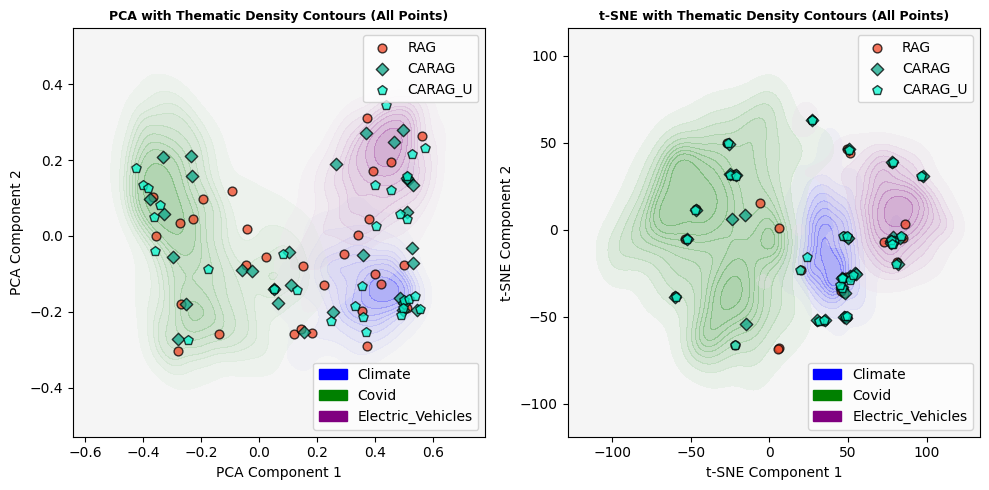

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, CARAG_U, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, carag_u_embeddings, *themed_data_embeddings.values()])
labels = (
    ['RAG'] * len(rag_embeddings)
    + ['CARAG'] * len(carag_embeddings)
    + ['CARAG_U'] * len(carag_u_embeddings)
    + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])
)

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_tsne = tsne_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Define distinct colors for each theme and approach
theme_colors = {
    'Climate': 'blue',
    'Covid': 'green',
    'Electric_Vehicles': 'purple'
}
approach_colors = {
    'RAG': '#F24726',  # Red
    'CARAG': '#0CA789',  # Teal
    'CARAG_U': '#08f9d1'  # Blue ##08f9d1 #cyan
}

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) #figsize=(8, 4.25)

# PCA plot with separate thematic densities
for theme, color in theme_colors.items():
    if themed_pca[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_pca[theme][:, 0],
            y=themed_pca[theme][:, 1],
            ax=axes[0],
            fill=True,
            cmap=sns.light_palette(color, as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
axes[0].scatter(rag_pca[:, 0], rag_pca[:, 1], color=approach_colors['RAG'], edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[0].scatter(carag_pca[:, 0], carag_pca[:, 1], color=approach_colors['CARAG'], edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[0].scatter(carag_u_pca[:, 0], carag_u_pca[:, 1], color=approach_colors['CARAG_U'], edgecolor='black', label='CARAG_U', s=50, marker='p', alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')

# t-SNE plot with separate thematic densities
for theme, color in theme_colors.items():
    if themed_tsne[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_tsne[theme][:, 0],
            y=themed_tsne[theme][:, 1],
            ax=axes[1],
            fill=True,
            cmap=sns.light_palette(color, as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
axes[1].scatter(rag_tsne[:, 0], rag_tsne[:, 1], color=approach_colors['RAG'], edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[1].scatter(carag_tsne[:, 0], carag_tsne[:, 1], color=approach_colors['CARAG'], edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[1].scatter(carag_u_tsne[:, 0], carag_u_tsne[:, 1], color=approach_colors['CARAG_U'], edgecolor='black', label='CARAG_U', s=50, marker='p', alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Add the first legend for scatter plot points
handles_points, labels_points = axes[0].get_legend_handles_labels()
scatter_legend = axes[0].legend(handles=handles_points, labels=labels_points, loc='upper right')#, title='Approaches'

# Add the second legend for thematic contours
theme_legend_patches = [mpatches.Patch(color=color, label=f"{theme}") for theme, color in theme_colors.items()]
contour_legend = axes[0].legend(handles=theme_legend_patches, loc='lower right')#, title='Thematic Contours'

# Add legends back manually
axes[0].add_artist(scatter_legend)

handles_points_tsne, labels_points_tsne = axes[1].get_legend_handles_labels()
scatter_legend_tsne = axes[1].legend(handles=handles_points_tsne, labels=labels_points_tsne, loc='upper right')#, title='Approaches'

contour_legend_tsne = axes[1].legend(handles=theme_legend_patches, loc='lower right')#, title='Thematic Contours'
axes[1].add_artist(scatter_legend_tsne)

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Debugging: Print dimensions of the arrays
print(f"DataFrame rows: {len(df)}")
print(f"rag_pca size: {rag_pca.shape[0]}, carag_pca size: {carag_pca.shape[0]}, carag_u_pca size: {carag_u_pca.shape[0]}")

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")


# Filter RAG, CARAG, and CARAG_U points by theme from the CSV file
rag_points = {}
carag_points = {}
carag_u_points = {}

for theme in themes:
    indices = df[df['Theme'] == theme].index
    valid_indices = indices[indices < rag_pca.shape[0]]  # Ensure indices are within bounds
    
    rag_points[theme] = rag_pca[np.array(valid_indices)]
    carag_points[theme] = carag_pca[np.array(valid_indices)]
    carag_u_points[theme] = carag_u_pca[np.array(valid_indices)]

    # Debugging: Print shapes of filtered data
    print(f"Theme '{theme}': {len(valid_indices)} points")

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG and CARAG_U points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}
carag_u_distances_pca = {theme: cdist(carag_u_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_u_distances_tsne = {theme: cdist(carag_u_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Prepare DataFrames for RAG, CARAG, and CARAG_U distances with difference columns
theme_tables = {}
for theme in themes:
    theme_table = []
    for i in range(len(rag_distances_pca[theme])):
        theme_table.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "CARAG_U Distance (PCA)": carag_u_distances_pca[theme][i],
            "Difference (PCA - CARAG)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "Difference (PCA - CARAG_U)": carag_u_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "CARAG_U Distance (t-SNE)": carag_u_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG_U)": carag_u_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    
    # Convert to DataFrame
    table_df = pd.DataFrame(theme_table)
    
    # Calculate averages for each numeric column
    averages = table_df.mean(numeric_only=True).to_dict()
    averages["Theme"] = f"{theme} - Average"
    averages["Point Index"] = "N/A"
    
    # Append averages as the last row using pd.concat
    average_row_df = pd.DataFrame([averages])
    table_df = pd.concat([table_df, average_row_df], ignore_index=True)
    
    theme_tables[theme] = table_df

# Display theme-specific tables with average rows
for theme, table in theme_tables.items():
    print(f"\nEuclidean Distance Table for Theme: {theme}")
    display(table)

# Step 5: Prepare a combined alignment comparison table
alignment_comparison = []
for theme in themes:
    rag_avg_distance_pca = np.mean(rag_distances_pca[theme])
    carag_avg_distance_pca = np.mean(carag_distances_pca[theme])
    carag_u_avg_distance_pca = np.mean(carag_u_distances_pca[theme])
    rag_avg_distance_tsne = np.mean(rag_distances_tsne[theme])
    carag_avg_distance_tsne = np.mean(carag_distances_tsne[theme])
    carag_u_avg_distance_tsne = np.mean(carag_u_distances_tsne[theme])

    alignment_comparison.append({
        "Theme": theme,
        "RAG Avg Distance (PCA)": rag_avg_distance_pca,
        "CARAG Avg Distance (PCA)": carag_avg_distance_pca,
        "CARAG_U Avg Distance (PCA)": carag_u_avg_distance_pca,
        "Difference (PCA - CARAG)": carag_avg_distance_pca - rag_avg_distance_pca,
        "Difference (PCA - CARAG_U)": carag_u_avg_distance_pca - rag_avg_distance_pca,
        "RAG Avg Distance (t-SNE)": rag_avg_distance_tsne,
        "CARAG Avg Distance (t-SNE)": carag_avg_distance_tsne,
        "CARAG_U Avg Distance (t-SNE)": carag_u_avg_distance_tsne,
        "Difference (t-SNE - CARAG)": carag_avg_distance_tsne - rag_avg_distance_tsne,
        "Difference (t-SNE - CARAG_U)": carag_u_avg_distance_tsne - rag_avg_distance_tsne,
        "Better Alignment (PCA)": "CARAG_U" if carag_u_avg_distance_pca < min(carag_avg_distance_pca, rag_avg_distance_pca) else 
                                   ("CARAG" if carag_avg_distance_pca < rag_avg_distance_pca else "RAG"),
        "Better Alignment (t-SNE)": "CARAG_U" if carag_u_avg_distance_tsne < min(carag_avg_distance_tsne, rag_avg_distance_tsne) else 
                                     ("CARAG" if carag_avg_distance_tsne < rag_avg_distance_tsne else "RAG")
    })

# Convert alignment comparison to a DataFrame
alignment_df = pd.DataFrame(alignment_comparison)

# Add an average row for the combined table using pd.concat
average_row = alignment_df.mean(numeric_only=True).to_dict()
average_row["Theme"] = "Overall Average"
average_row_df = pd.DataFrame([average_row])
alignment_df = pd.concat([alignment_df, average_row_df], ignore_index=True)

# Display the combined alignment comparison table with average row
print("\nCombined Alignment Comparison Table:")
display(alignment_df)

DataFrame rows: 31
rag_pca size: 31, carag_pca size: 31, carag_u_pca size: 31
Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']
Theme 'Climate': 10 points
Theme 'Covid': 10 points
Theme 'Electric_Vehicles': 10 points

Euclidean Distance Table for Theme: Climate


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Climate,0,0.063420,0.662598,0.142357,0.599178,0.078937,38.950807,39.619492,39.046606,0.668684,0.095799
1,Climate,1,0.214584,0.129313,0.144061,-0.085271,-0.070523,39.103211,38.834717,38.819943,-0.268494,-0.283268
2,Climate,2,0.051925,0.150246,0.160990,0.098321,0.109065,38.933871,38.815634,38.803393,-0.118237,-0.130478
3,Climate,3,0.156655,0.247677,0.150346,0.091021,-0.006309,38.911674,39.204033,38.817919,0.292359,-0.093756
4,Climate,4,0.161953,0.145520,0.180869,-0.016432,0.018917,38.802569,38.818487,38.784780,0.015918,-0.017788
5,Climate,5,0.134517,0.084447,0.079928,-0.050070,-0.054588,39.095044,38.987820,38.942936,-0.107224,-0.152108
6,Climate,6,0.270702,0.194062,0.205131,-0.076641,-0.065571,39.163324,38.770199,38.758888,-0.393125,-0.404436
7,Climate,7,0.344078,0.197146,0.118117,-0.146932,-0.225961,39.307836,38.829050,38.924932,-0.478786,-0.382904
8,Climate,8,0.511703,0.124145,0.227602,-0.387558,-0.284101,39.410234,39.046851,39.181183,-0.363383,-0.229051
9,Climate,9,0.151899,0.183344,0.149215,0.031445,-0.002684,38.843688,38.814623,38.815642,-0.029065,-0.028046



Euclidean Distance Table for Theme: Covid


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Covid,0,0.110304,0.223663,0.236590,0.113359,0.126287,31.513058,31.473250,31.307503,-0.039809,-0.205555
1,Covid,1,0.140987,0.249726,0.284800,0.108738,0.143813,31.349279,31.377000,31.284922,0.027720,-0.064357
2,Covid,2,0.299320,0.268416,0.263596,-0.030904,-0.035724,31.417206,31.416718,31.451927,-0.000489,0.034721
3,Covid,3,0.189260,0.197715,0.217591,0.008455,0.028331,31.340882,31.328206,31.324384,-0.012677,-0.016498
4,Covid,4,0.058719,0.132501,0.158356,0.073782,0.099637,31.476195,31.378346,31.364445,-0.097848,-0.111749
5,Covid,5,0.175609,0.173037,0.147933,-0.002572,-0.027676,31.430655,31.445164,31.343284,0.014509,-0.087372
6,Covid,6,0.178111,0.171570,0.159852,-0.006541,-0.018259,31.613444,31.475525,31.343717,-0.137919,-0.269726
7,Covid,7,0.645122,0.173627,0.580933,-0.471495,-0.064189,32.121228,31.641949,32.054437,-0.479279,-0.066791
8,Covid,8,0.372938,0.205101,0.570316,-0.167836,0.197378,31.854022,31.676245,32.028201,-0.177777,0.174179
9,Covid,9,0.555467,0.324388,0.616671,-0.231078,0.061204,32.044788,31.764292,32.105653,-0.280495,0.060866



Euclidean Distance Table for Theme: Electric_Vehicles


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Electric_Vehicles,0,0.202278,0.119794,0.114040,-0.082484,-0.088238,76.724987,76.788032,76.792447,0.063045,0.067460
1,Electric_Vehicles,1,0.678594,0.137247,0.130052,-0.541347,-0.548542,77.584217,77.030723,76.828769,-0.553494,-0.755448
2,Electric_Vehicles,2,0.496196,0.113547,0.067815,-0.382649,-0.428381,77.373812,76.793223,76.849163,-0.580589,-0.524649
3,Electric_Vehicles,3,0.106693,0.137517,0.195361,0.030824,0.088669,76.937613,76.773016,76.718710,-0.164597,-0.218903
4,Electric_Vehicles,4,0.467321,0.469700,0.618701,0.002379,0.151380,77.207580,77.199926,77.504466,-0.007654,0.296886
5,Electric_Vehicles,5,0.020899,0.164041,0.147062,0.143142,0.126163,76.907248,76.787057,76.766794,-0.120190,-0.140453
6,Electric_Vehicles,6,0.160745,0.122797,0.198960,-0.037948,0.038215,76.906911,76.917575,76.839217,0.010664,-0.067694
7,Electric_Vehicles,7,0.221757,0.145785,0.156392,-0.075972,-0.065365,77.033711,76.803054,76.806763,-0.230657,-0.226948
8,Electric_Vehicles,8,0.457449,0.350482,0.369804,-0.106967,-0.087645,77.357783,77.221830,77.242725,-0.135953,-0.115058
9,Electric_Vehicles,9,0.074025,0.119703,0.016442,0.045677,-0.057583,76.841690,76.823661,76.905159,-0.018029,0.063470



Combined Alignment Comparison Table:


,Theme,RAG Avg Distance (PCA),CARAG Avg Distance (PCA),CARAG_U Avg Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Avg Distance (t-SNE),CARAG Avg Distance (t-SNE),CARAG_U Avg Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U),Better Alignment (PCA),Better Alignment (t-SNE)
0,Climate,0.206144,0.211850,0.155862,0.005706,-0.050282,39.052226,38.974091,38.889622,-0.078135,-0.162603,CARAG_U,CARAG_U
1,Covid,0.272584,0.211974,0.323664,-0.060609,0.051080,31.616076,31.497669,31.560847,-0.118406,-0.055228,CARAG,CARAG
2,Electric_Vehicles,0.288596,0.188061,0.201463,-0.100534,-0.087133,77.087555,76.913810,76.925421,-0.173745,-0.162134,CARAG,CARAG
3,Overall Average,0.255774,0.203962,0.226996,-0.051813,-0.028778,49.251952,49.128523,49.125297,-0.123429,-0.126655,NaN,NaN


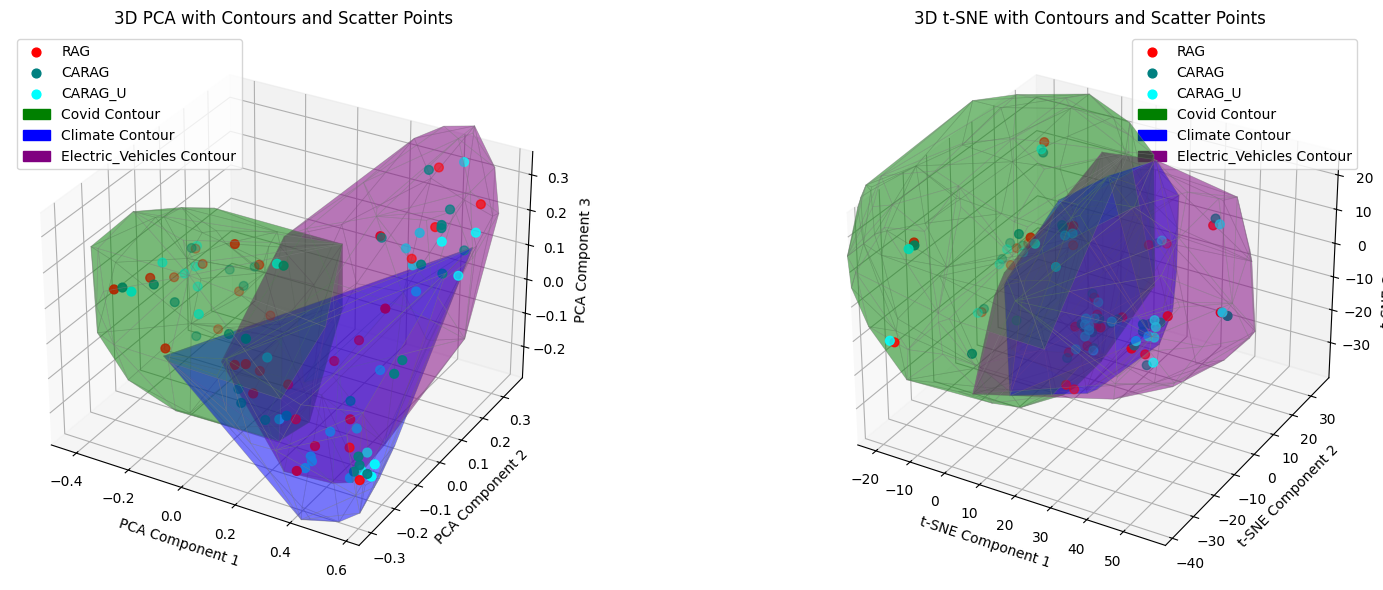

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches

# Define theme colors
theme_colors = {
    'Climate': 'blue',
    'Covid': 'green',
    'Electric_Vehicles': 'purple'
}

# Define scatter point colors
scatter_colors = {
    'RAG': 'red',
    'CARAG': 'teal',
    'CARAG_U': 'cyan'
}
# PCA transformation (3D)
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation (3D) # Separate embeddings for RAG, CARAG, CARAG_U, and themes
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_tsne = tsne_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Function to plot convex hulls for 3D data
def plot_3d_convex_hull(ax, points, color, alpha=0.3):
    if len(points) >= 4:  # ConvexHull requires at least 4 points in 3D
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            triangle = [[points[simplex[0]], points[simplex[1]], points[simplex[2]]]]
            poly = art3d.Poly3DCollection(triangle, alpha=alpha, facecolor=color, edgecolor='gray', linewidths=0.5)
            ax.add_collection3d(poly)

# Select themes for contours and scatter points
selected_themes = ['Covid', 'Climate', 'Electric_Vehicles']  # Contours for these themes
selected_scatter_themes = ['Covid', 'Climate', 'Electric_Vehicles']  # Scatter points for these themes

# Filter scatter points by theme for all types (RAG, CARAG, CARAG_U)
scatter_points_pca = {'RAG': [], 'CARAG': [], 'CARAG_U': []}
scatter_points_tsne = {'RAG': [], 'CARAG': [], 'CARAG_U': []}

for theme in selected_scatter_themes:
    indices = df[df['Theme'] == theme].index.tolist()
    scatter_points_pca['RAG'].extend(rag_pca[indices])
    scatter_points_pca['CARAG'].extend(carag_pca[indices])
    scatter_points_pca['CARAG_U'].extend(carag_u_pca[indices])
    scatter_points_tsne['RAG'].extend(rag_tsne[indices])
    scatter_points_tsne['CARAG'].extend(carag_tsne[indices])
    scatter_points_tsne['CARAG_U'].extend(carag_u_tsne[indices])

# Convert scatter points back to NumPy arrays
scatter_points_pca = {k: np.array(v) for k, v in scatter_points_pca.items()}
scatter_points_tsne = {k: np.array(v) for k, v in scatter_points_tsne.items()}

# Visualization for PCA (3D) and t-SNE (3D)
fig = plt.figure(figsize=(18, 6))

# PCA Plot
ax_pca = fig.add_subplot(121, projection='3d')

# Plot scatter points for PCA
for label, points in scatter_points_pca.items():
    if len(points) > 0:
        ax_pca.scatter(points[:, 0], points[:, 1], points[:, 2], color=scatter_colors[label], label=label, s=40)

# Plot selected theme contours for PCA
for theme in selected_themes:
    if theme in themed_pca:
        theme_points = themed_pca[theme]
        plot_3d_convex_hull(ax_pca, theme_points, color=theme_colors[theme], alpha=0.3)

# Add legend patches for selected themes (PCA)
theme_patches_pca = [
    mpatches.Patch(color=theme_colors[theme], label=f'{theme} Contour')
    for theme in selected_themes if theme in theme_colors
]
scatter_legend_handles_pca, scatter_legend_labels_pca = ax_pca.get_legend_handles_labels()
ax_pca.legend(handles=scatter_legend_handles_pca + theme_patches_pca,
              labels=scatter_legend_labels_pca + [f'{theme} Contour' for theme in selected_themes if theme in theme_colors],
              loc='best')

ax_pca.set_title("3D PCA with Contours and Scatter Points")
ax_pca.set_xlabel("PCA Component 1")
ax_pca.set_ylabel("PCA Component 2")
ax_pca.set_zlabel("PCA Component 3")

# t-SNE Plot
ax_tsne = fig.add_subplot(122, projection='3d')

# Plot scatter points for t-SNE
for label, points in scatter_points_tsne.items():
    if len(points) > 0:
        ax_tsne.scatter(points[:, 0], points[:, 1], points[:, 2], color=scatter_colors[label], label=label, s=40)

# Plot selected theme contours for t-SNE
for theme in selected_themes:
    if theme in themed_tsne:
        theme_points = themed_tsne[theme]
        plot_3d_convex_hull(ax_tsne, theme_points, color=theme_colors[theme], alpha=0.3)

# Add legend patches for selected themes (t-SNE)
theme_patches_tsne = [
    mpatches.Patch(color=theme_colors[theme], label=f'{theme} Contour')
    for theme in selected_themes if theme in theme_colors
]
scatter_legend_handles_tsne, scatter_legend_labels_tsne = ax_tsne.get_legend_handles_labels()
ax_tsne.legend(handles=scatter_legend_handles_tsne + theme_patches_tsne,
               labels=scatter_legend_labels_tsne + [f'{theme} Contour' for theme in selected_themes if theme in theme_colors],
               loc='best')

ax_tsne.set_title("3D t-SNE with Contours and Scatter Points")
ax_tsne.set_xlabel("t-SNE Component 1")
ax_tsne.set_ylabel("t-SNE Component 2")
ax_tsne.set_zlabel("t-SNE Component 3")

plt.tight_layout()
plt.show()